In [17]:
#imports
import pandas as pd
import xarray as xr
import numpy as np
import datetime
import os
import yaml

import matplotlib.pyplot as plt
import cmocean as cm    

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, max_error, mean_squared_error, mean_absolute_error, median_absolute_error

In [18]:
#This file contains configuration details like API keys and passwords
global_vars = yaml.safe_load(open('../config.yml', 'r') )

#This has custom functions - model evaluation and graphing
%run './00_custom_functions.ipynb'
#more functions for flux conversions
%run './00_co2_flux_equations.ipynb'

In [19]:
#Set base folders
input_folder_root = global_vars['reconstruction_folder']
output_folder = input_folder_root #Because we are inputting and outputting processed files, the folder can be the same

full_dataset_file = input_folder_root + 'HPD_LEAP_fco2-full-dataset-preML_2024models_198201-202312.nc' #name of file from previous script (03_datframe)
print(full_dataset_file)

#This variable sets the output file type. 
#When using cloud storage, it is recommended to use ARCO (Analysis-Ready Cloud-Optimized) formats like Zarr over NetCDF
output_file_type = '.zarr' if input_folder_root[0:5] == 'gs://' else '.nc'
print(f'Files will be outputed as: {output_file_type}')

/data/artemis/workspace/afay/LDEO_HPD/data/HPD_LEAP_fco2-full-dataset-preML_2024models_198201-202312.nc
Files will be outputed as: .nc


In [20]:
#The following two variables will cut the data to use for training (and prediction)
ml_start_yearmonth = '1982-01'  
ml_end_yearmonth = '2023-12'   

# Parameters from prior exploration (all the way back to Luke's work) for consistency:
random_seeds = np.array([97]) #historically used for train/test split #random_seeds = [97, 62, 12] # LDEO HPD. set random numbers to initiate it. 
print(f'Random Seeds {random_seeds}')
best_params = {        'random_state':42,
                      'max_depth': 9, 
                      'min_child_weight': 1, 
                      'gamma': 0,
                      'subsample': 0.85,
                      'colsample_bytree': 0.95,
                      'reg_alpha': 0.09,
                      'reg_lambda': 1,
                      'n_estimators': 1500,
                      'learning_rate': 0.05,
                     }



jobs = -1         #Number of cores you have access to for model training; -1 for all available ones

#This variable is a list of features used for machine learning
#Note that the net_mask variable will be used regardless to only train on ocean areas (not land or coast)
feature_sel = ['sst','sst_anomaly','sss','sss_anomaly','chl_log','chl_log_anomaly','mld_log','xco2_trend','A','B','C','T0','T1']
#target_sel = ['error']  



Random Seeds [97]


In [21]:
#########CHANGE THIS TO MATCH THE MODEL NAMES EACH YEAR ######

#This variable is a list of GOBM models in which to calculate the error correction. It should match the variable names in the dataframe.
gobm_list = ['cnrm', 'fesom2', 'ipsl', 'princeton', 
               'mri','noresm', 'planktom',
             'cesm_ethz','mpi','access']

In [22]:
#for debugging
#ml_start_yearmonth = '2022-01'  
#ml_end_yearmonth = '2022-12' 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load and Prep Dataframe

In [23]:
#df03 = xr.open_dataset('/data/artemis/workspace/afay/LDEO_HPD/models/XGB/GCB_2023/HPD_2023_df_preML_v2_198201-202304.nc')
df03 = xr.open_dataset(full_dataset_file)
assert df03.get(gobm_list) is not None #if error, check the GOBM list above matches the dataframe variable names

df03 = df03.sel(time=slice(str(ml_start_yearmonth),str(ml_end_yearmonth))) #filter time frame
# xr_full_mod_output =  df03.get(['fco2','net_mask'] + gobm_list)   #base xr that is our output. error correction values will be added to this

xr_full_mod_output =  df03.get(['fco2','full_mask'] + gobm_list)   #base xr that is our output. error correction values wil

In [24]:
%%time 

#Main loop to learn error correction
for mod in gobm_list:
    print(f'----------Starting {mod} on '+datetime.datetime.now().strftime('%Y-%m-%d %H:%M')+'...----------')
    
    #filter data for relevant rows and columns
    xr_for_ml = df03.get(feature_sel + ['fco2'] + [mod] + ['net_mask'])
    # xr_for_ml = df03.get(feature_sel + ['fco2'] + [mod] + ['full_mask']) #if we wanted to try with a full mask
    xr_for_ml = xr_for_ml.assign( error = xr_for_ml.fco2 - xr_for_ml[mod])
    df = xr_for_ml.to_dataframe() #for ease of working with pandas
    df_for_ml = df[(~df.isna().any(axis=1))]  #only keep points that are not null
    print(f'Number of points in time/space available to train: {df_for_ml.shape[0]}')
    df_for_recon = df.loc[:,feature_sel + ['net_mask']]
    # df_for_recon = df.loc[:,feature_sel + ['full_mask']] #if we wanted to try with a full mask
    df_for_recon = df_for_recon[(~df_for_recon.isna().any(axis=1))]  
    print(f'Number of points in time/space to reconstruct: {df_for_recon.shape[0]}')
    
    #df_for_ml = df_for_ml.drop('net_mask', axis=1) #remove net_mask variable since not used in training? Prior code has it in; since all 1 value no impact

    #split into train and test sets 
        #original code created train, validation, and test sets but because development already completed and no more cross validation/hyperparameter tuning, we can just use train/test
        #note that according to historic work, we do not divide based on time meaning all rows are scrambled and used IID to train
    df_train, df_test = train_test_split(df_for_ml, test_size=0.2, random_state=random_seeds[0])
    X_train = df_train.loc[:,feature_sel]
    y_train = df_train.loc[:,'error']
    X_test = df_test.loc[:,feature_sel]
    y_test = df_test.loc[:,'error']
    
    print('-------Training...')
    model = XGBRegressor(**best_params, n_jobs=jobs)
    model.fit(X_train, y_train) 
    print('-------Evaluating Performance...-------')
    y_pred_test = model.predict(X_test)
    test_performance = evaluate_test(y_test.to_numpy().ravel(), y_pred_test)
    print_dict_as_table(test_performance) #print(test_performance)
    
    #do we save anything from model? Perhaps just the reconstruction
    print('-------Reconstructing...')
    error_correction = model.predict(df_for_recon.loc[:,feature_sel])
    df_for_recon[mod+'_error_correction'] = error_correction #add predictions back to dataframe
    xr_recon = df_for_recon[mod+'_error_correction'].to_xarray() #convert back to xr to merge
    xr_full_mod_output = xr_full_mod_output.merge(xr_recon, compat='identical')
    
    print(f'GOBM Model Complete \n')

----------Starting cnrm on 2024-09-24 11:53...----------
Number of points in time/space available to train: 322485
Number of points in time/space to reconstruct: 18652758
-------Training...
-------Evaluating Performance...-------
mse      : 224.224      bias     : 0.044        stdev    : 30.013       iqr_ref  : 34.711       
mae      : 9.624        r2       : 0.814        amp_ratio: 0.750                                
medae    : 6.334        corr     : 0.903        stdev_ref: 34.693                               
max_error: 282.735      cent_rmse: 14.974       range_ref: 744.299                              

-------Reconstructing...
GOBM Model Complete 

----------Starting fesom2 on 2024-09-24 11:59...----------
Number of points in time/space available to train: 309732
Number of points in time/space to reconstruct: 18652758
-------Training...
-------Evaluating Performance...-------
mse      : 208.106      bias     : 0.072        stdev    : 33.491       iqr_ref  : 42.937       
mae  

In [25]:
xr_full_mod_output

<xarray.Dataset>
Dimensions:                     (time: 504, xlon: 360, ylat: 180)
Coordinates:
  * ylat                        (ylat) float64 -89.5 -88.5 -87.5 ... 88.5 89.5
  * time                        (time) datetime64[ns] 1982-01-15 ... 2023-12-15
  * xlon                        (xlon) float64 -179.5 -178.5 ... 178.5 179.5
Data variables: (12/22)
    fco2                        (time, ylat, xlon) float32 ...
    full_mask                   (ylat, xlon) float32 ...
    cnrm                        (time, ylat, xlon) float64 ...
    fesom2                      (time, ylat, xlon) float64 ...
    ipsl                        (time, ylat, xlon) float64 ...
    princeton                   (time, ylat, xlon) float64 ...
    ...                          ...
    mri_error_correction        (time, xlon, ylat) float32 nan nan ... nan nan
    noresm_error_correction     (time, xlon, ylat) float32 nan nan ... nan nan
    planktom_error_correction   (time, xlon, ylat) float32 nan nan ... nan nan
    cesm_ethz_error_correction  (time, xlon, ylat) float32 nan nan ... nan nan
    mpi_error_correction        (time, xlon, ylat) float32 nan nan ... nan nan
    access_error_correction     (time, xlon, ylat) float32 nan nan ... nan nan

In [12]:

#output to file
#this saves the original models (that went into the ML method) and the error reconstructions. 
#In another code we will add them together (model+error) and then average over all of themto get our final HPD estimate

output_xarray_with_date(xr_full_mod_output, result_folder+'', 'HPD_LEAP_fco2-error-reconstructed-10-GOBMs_2024models', filetype=output_file_type)

Saved HPD_LEAP_fco2-error-reconstructed-10-GOBMs_2024models_198201-202312.nc to /data/artemis/workspace/afay/LDEO_HPD/models/XGB/GCB_2024/reconstructions/xg


'/data/artemis/workspace/afay/LDEO_HPD/data/'

### View Results

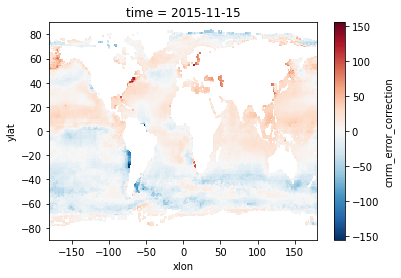

In [28]:
xr_full_mod_output['cnrm_error_correction'][406,:,:].transpose().plot();

In [15]:
#CESM reconstruction (model+error)
CESM_recon = xr_full_mod_output['cesm_ethz'] + xr_full_mod_output['cesm_ethz_error_correction']

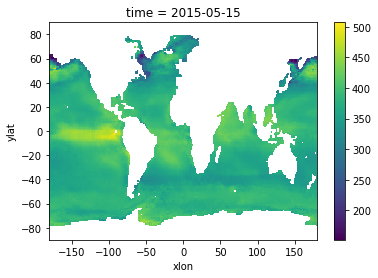

In [16]:
CESM_recon[400,:,:].plot()